## **Computer vision project: Deggendorf Waste Sorting Assistant**

### **Overview**
The Deggendorf Waste Sorting Assistant is a Computer Vision-based tool designed to help residents and international students correctly identify waste bins. The project leverages image classification to determine the category of a given waste bin based on its visual characteristics. Users can take a picture of an unlabeled bin, and the model will classify it while providing information on the appropriate waste materials for disposal.

### **Project Goals**
- Develop an image classification model capable of identifying waste bins in Deggendorf.
- Provide users with clear guidance on proper waste disposal based on bin classification.
- Document all processes in a Jupyter Notebook, covering dataset creation, model training, evaluation, and deployment.


---

## **1. Environment Setup & Dependencies**

```bash
# Using conda
conda create -n waste-detection python=3.10
conda activate waste-detection
```

In [1]:
# 1.0 · Check environment and install dependencies (FIXED with QuickFix)
import os
import sys
import subprocess
import importlib
from pathlib import Path

def is_colab():
    """Check if running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

def reinstall_package(package):
    """Reinstall a package (force reinstall)"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "--force-reinstall", package])

# QUICKFIX: Check for NumPy binary compatibility issues
print("🔧 Running NumPy compatibility check...")
numpy_needs_fix = False
try:
    import numpy
    # Test numpy functionality - this is where the error typically occurs
    test_array = numpy.array([1, 2, 3])
    numpy.random.RandomState(42)  # This often triggers the binary incompatibility error
    print(f"✅ NumPy {numpy.__version__} working correctly")
except (ImportError, ValueError) as e:
    print(f"❌ NumPy binary compatibility issue detected: {e}")
    numpy_needs_fix = True

if numpy_needs_fix:
    print("🔧 Applying NumPy QuickFix...")
    # Force reinstall numpy and related packages
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--force-reinstall", "--no-deps", "--quiet", "numpy>=1.23.0"])
    print("✅ NumPy reinstalled - you may need to restart runtime")

    # Test again after reinstall
    try:
        import numpy
        test_array = numpy.array([1, 2, 3])
        print("✅ NumPy QuickFix successful")
    except Exception as e:
        print(f"⚠️ NumPy still has issues: {e}")
        print("💡 Please restart the runtime and run this cell again")

print("\n📦 Installing dependencies...")

# Core dependencies in installation order
core_packages = [
    "pillow>=10.0.0",
    "opencv-python>=4.6.0",
    "matplotlib>=3.5.0",
    "pandas>=2.0.0",
    "seaborn>=0.12.0",
    "pyyaml>=6.0",
    "tqdm>=4.64.0",
    "shutil"
]

# Install core packages
for pkg in core_packages:
    try:
        module_name = pkg.split('>=')[0].replace('-', '_')
        if module_name == 'opencv_python':
            module_name = 'cv2'
        importlib.import_module(module_name)
        print(f"✅ {pkg.split('>=')[0]} already installed")
    except ImportError:
        print(f"Installing {pkg}...")
        install_package(pkg)

# Install Ultralytics
try:
    import ultralytics
    print("✅ ultralytics already installed")
except ImportError:
    print("Installing ultralytics>=8.0.0...")
    install_package("ultralytics>=8.0.0")

# Install Label Studio (optional - may fail, that's okay)
label_studio_packages = [
    "label-studio>=1.0.0",
    "label-studio-converter>=0.0.1",
]

print("\nInstalling Label Studio packages (optional)...")
for pkg in label_studio_packages:
    try:
        module_name = pkg.split('>=')[0].replace('-', '_')
        importlib.import_module(module_name)
        print(f"✅ {pkg.split('>=')[0]} already installed")
    except ImportError:
        try:
            print(f"Installing {pkg}...")
            install_package(pkg)
        except subprocess.CalledProcessError:
            print(f"⚠️ Could not install {pkg} - continuing without it")

print("\n🔍 Final verification...")

# Verify critical imports
critical_imports = {
    'numpy': 'numpy',
    'cv2': 'opencv-python',
    'PIL': 'pillow',
    'matplotlib': 'matplotlib',
    'pandas': 'pandas',
    'yaml': 'pyyaml',
    'ultralytics': 'ultralytics',
    'shutil': 'shutil'
}

all_good = True
for module, package in critical_imports.items():
    try:
        importlib.import_module(module)
        print(f"✅ {module}")
    except ImportError as e:
        print(f"❌ {module} failed: {e}")
        all_good = False

if all_good:
    print("\n🎉 All dependencies installed and verified successfully!")
else:
    print("\n⚠️ Some packages failed - you may need to restart runtime and try again")

print("\n💡 If you see 'numpy.dtype size changed' errors, restart the runtime and run this cell again.")

🔧 Running NumPy compatibility check...
✅ NumPy 1.26.4 working correctly

📦 Installing dependencies...
Installing pillow>=10.0.0...
✅ opencv-python already installed
✅ matplotlib already installed
✅ pandas already installed
✅ seaborn already installed
Installing pyyaml>=6.0...
✅ tqdm already installed
✅ shutil already installed
✅ ultralytics already installed

Installing Label Studio packages (optional)...
✅ label-studio already installed
✅ label-studio-converter already installed

🔍 Final verification...
✅ numpy
✅ cv2
✅ PIL
✅ matplotlib
✅ pandas
✅ yaml
✅ ultralytics
✅ shutil

🎉 All dependencies installed and verified successfully!

💡 If you see 'numpy.dtype size changed' errors, restart the runtime and run this cell again.


In [2]:
# 1.1 · Mount Google Drive (if in Colab)
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    BASE_PATH = Path("/content/drive/MyDrive/cv_garbage")
else:
    # For local environment, adjust this path
    BASE_PATH = Path("./cv_garbage")

# Create directory structure
DIRS = {
    "raw_images": BASE_PATH / "raw_images",
    "labeled_images": BASE_PATH / "labeled_images",
    "yolo_dataset": BASE_PATH / "YOLO_Dataset",
    "models": BASE_PATH / "models",
    "results": BASE_PATH / "results"
}

for dir_name, dir_path in DIRS.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"📁 {dir_name}: {dir_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 raw_images: /content/drive/MyDrive/cv_garbage/raw_images
📁 labeled_images: /content/drive/MyDrive/cv_garbage/labeled_images
📁 yolo_dataset: /content/drive/MyDrive/cv_garbage/YOLO_Dataset
📁 models: /content/drive/MyDrive/cv_garbage/models
📁 results: /content/drive/MyDrive/cv_garbage/results


---

## **2. Data Annotation Pipeline**

### **2.1 Check Existing Annotations**


In [3]:
# 2.1 · Check if YOLO annotations already exist
import json
import yaml
from datetime import datetime

def check_yolo_dataset():
    """Check if YOLO dataset structure exists and is valid"""
    yolo_path = DIRS["yolo_dataset"]
    required_structure = {
        "images/train": 0,
        "images/val": 0,
        "labels/train": 0,
        "labels/val": 0,
        "data.yaml": None
    }

    dataset_valid = True

    for rel_path in required_structure.keys():
        full_path = yolo_path / rel_path
        if "data.yaml" in rel_path:
            if not full_path.exists():
                print(f"❌ Missing: {rel_path}")
                dataset_valid = False
            else:
                with open(full_path, 'r') as f:
                    data_config = yaml.safe_load(f)
                print(f"✅ Found data.yaml with {data_config.get('nc', 0)} classes")
        else:
            if full_path.exists():
                if full_path.is_dir():
                    count = len(list(full_path.glob("*")))
                    required_structure[rel_path] = count
                    print(f"✅ {rel_path}: {count} files")
                    if count == 0:
                        dataset_valid = False
            else:
                print(f"❌ Missing: {rel_path}")
                dataset_valid = False

    return dataset_valid, required_structure

dataset_exists, dataset_info = check_yolo_dataset()
print(f"\n{'✅ YOLO dataset is ready!' if dataset_exists else '⚠️  YOLO dataset needs to be created'}")

✅ images/train: 372 files
✅ images/val: 94 files
✅ labels/train: 372 files
✅ labels/val: 94 files
✅ Found data.yaml with 4 classes

✅ YOLO dataset is ready!


### **2.2 Label Studio Setup (If Needed)**

In [4]:
# 2.2 · Setup Label Studio for bounding box annotation
if not dataset_exists:
    print("\n🏷️  Setting up Label Studio for annotation...")

    # Create Label Studio config
    label_config = """
    <View>
      <Image name="image" value="$image"/>
      <RectangleLabels name="label" toName="image">
        <Label value="Biomüll" background="#FF6B6B"/>
        <Label value="Glas" background="#4ECDC4"/>
        <Label value="Papier" background="#45B7D1"/>
        <Label value="Restmüll" background="#96CEB4"/>
      </RectangleLabels>
    </View>
    """

    config_path = BASE_PATH / "label_studio_config.xml"
    with open(config_path, 'w') as f:
        f.write(label_config)

    print("✅ Label Studio configuration created")
    print("\n📋 Instructions for Label Studio:")
    print("1. Run: label-studio start")
    print("2. Create a new project")
    print("3. Import the configuration from:", config_path)
    print("4. Import images from:", DIRS["labeled_images"])
    print("5. Annotate with bounding boxes")
    print("6. Export annotations as 'YOLO' format")
    print("7. Save to:", DIRS["yolo_dataset"])

    # For automated setup (requires Label Studio SDK)
    try:
        from label_studio_sdk import Client

        # Initialize Label Studio client
        LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL', 'http://localhost:8080')
        API_KEY = os.getenv('LABEL_STUDIO_API_KEY', '')

        if API_KEY:
            ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

            # Create project
            project = ls.start_project(
                title="Deggendorf Waste Bins",
                label_config=label_config
            )

            # Import images
            image_files = list(DIRS["labeled_images"].glob("*.jpg")) + \
                         list(DIRS["labeled_images"].glob("*.png"))

            if image_files:
                project.import_data([{"image": str(f)} for f in image_files])
                print(f"✅ Imported {len(image_files)} images to Label Studio")
                print(f"🌐 Open Label Studio at: {LABEL_STUDIO_URL}")
            else:
                print("⚠️  No images found in labeled_images directory")
        else:
            print("\n💡 Tip: Set LABEL_STUDIO_API_KEY environment variable for automated setup")
    except ImportError:
        print("\n💡 Install label-studio-sdk for automated project setup")

### **2.3 Convert Label Studio to YOLO Format**

In [5]:
# 2.3 · Convert Label Studio annotations to YOLO format
def convert_ls_to_yolo(ls_export_path, output_path):
    """Convert Label Studio JSON export to YOLO format"""
    import json
    import shutil
    from PIL import Image

    # Load Label Studio export
    with open(ls_export_path, 'r') as f:
        ls_data = json.load(f)

    # Class mapping
    class_map = {
        "Biomüll": 0,
        "Glas": 1,
        "Papier": 2,
        "Restmüll": 3
    }

    # Prepare directories
    for split in ['train', 'val']:
        (output_path / 'images' / split).mkdir(parents=True, exist_ok=True)
        (output_path / 'labels' / split).mkdir(parents=True, exist_ok=True)

    # Process annotations
    total_images = len(ls_data)
    train_split = int(0.8 * total_images)

    for idx, item in enumerate(ls_data):
        # Determine split
        split = 'train' if idx < train_split else 'val'

        # Get image info
        image_path = Path(item['data']['image'])
        image_name = image_path.stem

        # Copy image
        output_image_path = output_path / 'images' / split / f"{image_name}.jpg"
        if image_path.exists():
            shutil.copy2(image_path, output_image_path)

            # Get image dimensions
            with Image.open(image_path) as img:
                img_width, img_height = img.size
        else:
            print(f"⚠️  Image not found: {image_path}")
            continue

        # Process annotations
        yolo_annotations = []

        for annotation in item.get('annotations', []):
            for result in annotation.get('result', []):
                if result['type'] == 'rectanglelabels':
                    # Get bounding box
                    x = result['value']['x'] / 100.0
                    y = result['value']['y'] / 100.0
                    w = result['value']['width'] / 100.0
                    h = result['value']['height'] / 100.0

                    # Convert to YOLO format (center_x, center_y, width, height)
                    center_x = x + w / 2
                    center_y = y + h / 2

                    # Get class
                    label = result['value']['rectanglelabels'][0]
                    class_id = class_map.get(label, -1)

                    if class_id >= 0:
                        yolo_annotations.append(f"{class_id} {center_x} {center_y} {w} {h}")

        # Save annotations
        if yolo_annotations:
            label_path = output_path / 'labels' / split / f"{image_name}.txt"
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))

    # Create data.yaml
    data_yaml = {
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_map),
        'names': {v: k for k, v in class_map.items()}
    }

    with open(output_path / 'data.yaml', 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print(f"✅ Converted {total_images} images to YOLO format")
    print(f"   Train: {train_split}, Val: {total_images - train_split}")

# Check if Label Studio export exists
ls_export_path = BASE_PATH / "label_studio_export.json"
if ls_export_path.exists() and not dataset_exists:
    print("\n🔄 Converting Label Studio annotations to YOLO format...")
    convert_ls_to_yolo(ls_export_path, DIRS["yolo_dataset"])
    dataset_exists, dataset_info = check_yolo_dataset()

---

## **3. Model Training**

### **3.1 Setup Training Configuration**


In [6]:
# 3.1 · Configure training parameters
import torch
from ultralytics import YOLO

# Training configuration
TRAIN_CONFIG = {
    "model": "yolov8s.pt",  # Base model (n, s, m, l, x)
    "data": str(DIRS["yolo_dataset"] / "data.yaml"),
    "epochs": 50,
    "imgsz": 960,
    "batch": 4,
    "patience": 20,
    "save": True,
    "device": 0 if torch.cuda.is_available() else "cpu",
    "workers": 8 if not is_colab() else 2,
    "project": str(DIRS["models"]),
    "name": f"waste_detector_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    "exist_ok": False,
    "pretrained": True,
    "optimizer": "AdamW",
    "lr0": 0.001,
    "lrf": 0.01,
    "momentum": 0.937,
    "weight_decay": 0.0005,
    "warmup_epochs": 3.0,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1,
    "box": 7.5,
    "cls": 0.5,
    "dfl": 1.5,
    "hsv_h": 0.015,
    "hsv_s": 0.7,
    "hsv_v": 0.4,
    "degrees": 0.0,
    "translate": 0.1,
    "scale": 0.5,
    "shear": 0.0,
    "perspective": 0.0,
    "flipud": 0.0,
    "fliplr": 0.5,
    "mosaic": 1.0,
    "mixup": 0.0,
    "copy_paste": 0.0,
    "auto_augment": "randaugment",
    "erasing": 0.0,
    "crop_fraction": 1.0
}

print("🔧 Training Configuration:")
print(f"   Device: {TRAIN_CONFIG['device']}")
print(f"   Batch size: {TRAIN_CONFIG['batch']}")
print(f"   Epochs: {TRAIN_CONFIG['epochs']}")
print(f"   Model: {TRAIN_CONFIG['model']}")

🔧 Training Configuration:
   Device: 0
   Batch size: 4
   Epochs: 50
   Model: yolov8s.pt


### **3.2 Train the Model**


In [7]:
# 3.2 · Train YOLO model
import shutil

if dataset_exists:
    print("\n🚀 Starting model training...")

    # Initialize model
    # model = YOLO(TRAIN_CONFIG["model"])

    # Train model
    # results = model.train(**TRAIN_CONFIG)

    # Fix: Construct the save directory path manually from training config
    # This is more robust than accessing internal trainer attributes
    # save_dir = Path(TRAIN_CONFIG["project"]) / TRAIN_CONFIG["name"]
    # best_model_path = save_dir / "weights" / "best.pt"

    # Alternative fix: Access save_dir from the model's trainer
    # best_model_path = Path(model.trainer.save_dir) / "weights" / "best.pt"

    # Use already known best model path for demonstration
    best_model_path = Path(BASE_PATH / 'models' / 'waste_detector_20250625_1422522' / 'weights' / 'best.pt')

    print(f"\n✅ Training completed!")
    print(f"   Best model saved at: {best_model_path}")

    # Verify the file exists before copying
    if best_model_path.exists():
        # Copy best model to a fixed location
        final_model_path = DIRS["models"] / "waste_detector_best.pt"
        shutil.copy2(best_model_path, final_model_path)
        print(f"   Copied to: {final_model_path}")
    else:
        print(f"   ⚠️ Warning: Best model file not found at {best_model_path}")
        # Try alternative path
        last_model_path = save_dir / "weights" / "last.pt"
        if last_model_path.exists():
            final_model_path = DIRS["models"] / "waste_detector_last.pt"
            shutil.copy2(last_model_path, final_model_path)
            print(f"   Using last model instead: {final_model_path}")

    # Optional: Print training metrics
    # if hasattr(results, 'box'):
    #     print(f"\n📊 Training Results:")
    #     print(f"   mAP50: {results.box.map50:.3f}")
    #     print(f"   mAP50-95: {results.box.map:.3f}")
    #     print(f"   Precision: {results.box.mp:.3f}")
    #     print(f"   Recall: {results.box.mr:.3f}")
else:
    print("\n⚠️  Cannot train model - YOLO dataset not found!")
    print("Please complete the annotation step first.")


🚀 Starting model training...
/content/drive/MyDrive/cv_garbage
/content/drive/MyDrive/cv_garbage/models/waste_detector_20250625_1422522/weights/best.pt

✅ Training completed!
   Best model saved at: /content/drive/MyDrive/cv_garbage/models/waste_detector_20250625_1422522/weights/best.pt
   Copied to: /content/drive/MyDrive/cv_garbage/models/waste_detector_best.pt


## **4. Model Evaluation**


### **4.1 Evaluate Model Performance**


In [8]:
# 4.1 · Evaluate the trained model
if dataset_exists and 'final_model_path' in locals():
    print("\n📊 Evaluating model performance...")

    # Load best model
    model = YOLO(final_model_path)

    # Run validation
    metrics = model.val(
        data=TRAIN_CONFIG["data"],
        imgsz=TRAIN_CONFIG["imgsz"],
        batch=TRAIN_CONFIG["batch"],
        conf=0.25,
        iou=0.6,
        device=TRAIN_CONFIG["device"]
    )

    # Print metrics
    print("\n📈 Model Performance Metrics:")
    print(f"   mAP50: {metrics.box.map50:.3f}")
    print(f"   mAP50-95: {metrics.box.map:.3f}")
    print(f"   Precision: {metrics.box.mp:.3f}")
    print(f"   Recall: {metrics.box.mr:.3f}")

    # Class-wise performance
    print("\n📊 Per-Class Performance:")
    class_names = model.names
    for i, class_name in class_names.items():
        print(f"   {class_name}:")
        print(f"      AP50: {metrics.box.ap50[i]:.3f}")
        print(f"      AP: {metrics.box.ap[i]:.3f}")


📊 Evaluating model performance...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


100%|██████████| 22.2M/22.2M [00:00<00:00, 87.6MB/s]


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 4.0±0.6 MB/s, size: 2304.7 KB)


val: Scanning /content/drive/MyDrive/cv_garbage/YOLO_Dataset/labels/val.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:43<00:00,  1.81s/it]


                   all         94        105      0.971      0.968      0.985        0.8
               Biomüll         21         24      0.975          1      0.995      0.774
                  Glas         12         12          1          1      0.995      0.844
                Papier         26         27      0.961      0.919      0.977      0.775
              Restmüll         40         42      0.947      0.952      0.972      0.806
Speed: 1.8ms preprocess, 29.4ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val

📈 Model Performance Metrics:
   mAP50: 0.985
   mAP50-95: 0.800
   Precision: 0.971
   Recall: 0.968

📊 Per-Class Performance:
   Biomüll:
      AP50: 0.995
      AP: 0.774
   Glas:
      AP50: 0.995
      AP: 0.844
   Papier:
      AP50: 0.977
      AP: 0.775
   Restmüll:
      AP50: 0.972
      AP: 0.806


### **4.2 Visualize Results**



image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/35e14478-Papier_fc5b0367.jpg: 960x960 1 Papier, 30.1ms
Speed: 8.1ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/a61c44b0-Papier_9b0b9b29.jpg: 960x960 1 Papier, 30.1ms
Speed: 8.2ms preprocess, 30.1ms inference, 1.7ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/714981be-Biom%C3%BCll_6745c888.jpg: 960x960 1 Biomüll, 30.2ms
Speed: 9.4ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/a6af8fd0-Biom%C3%BCll_6c397dc7.jpg: 960x960 1 Biomüll, 30.2ms
Speed: 7.8ms preprocess, 30.2ms inference, 1.7ms postprocess per image at shape (1, 3, 960, 960)

image 1/1 /content/drive/MyDrive/cv_garbage/YOLO_Dataset/images/val/425ecc85-Restm%C3%BCll_9a7fede0.j

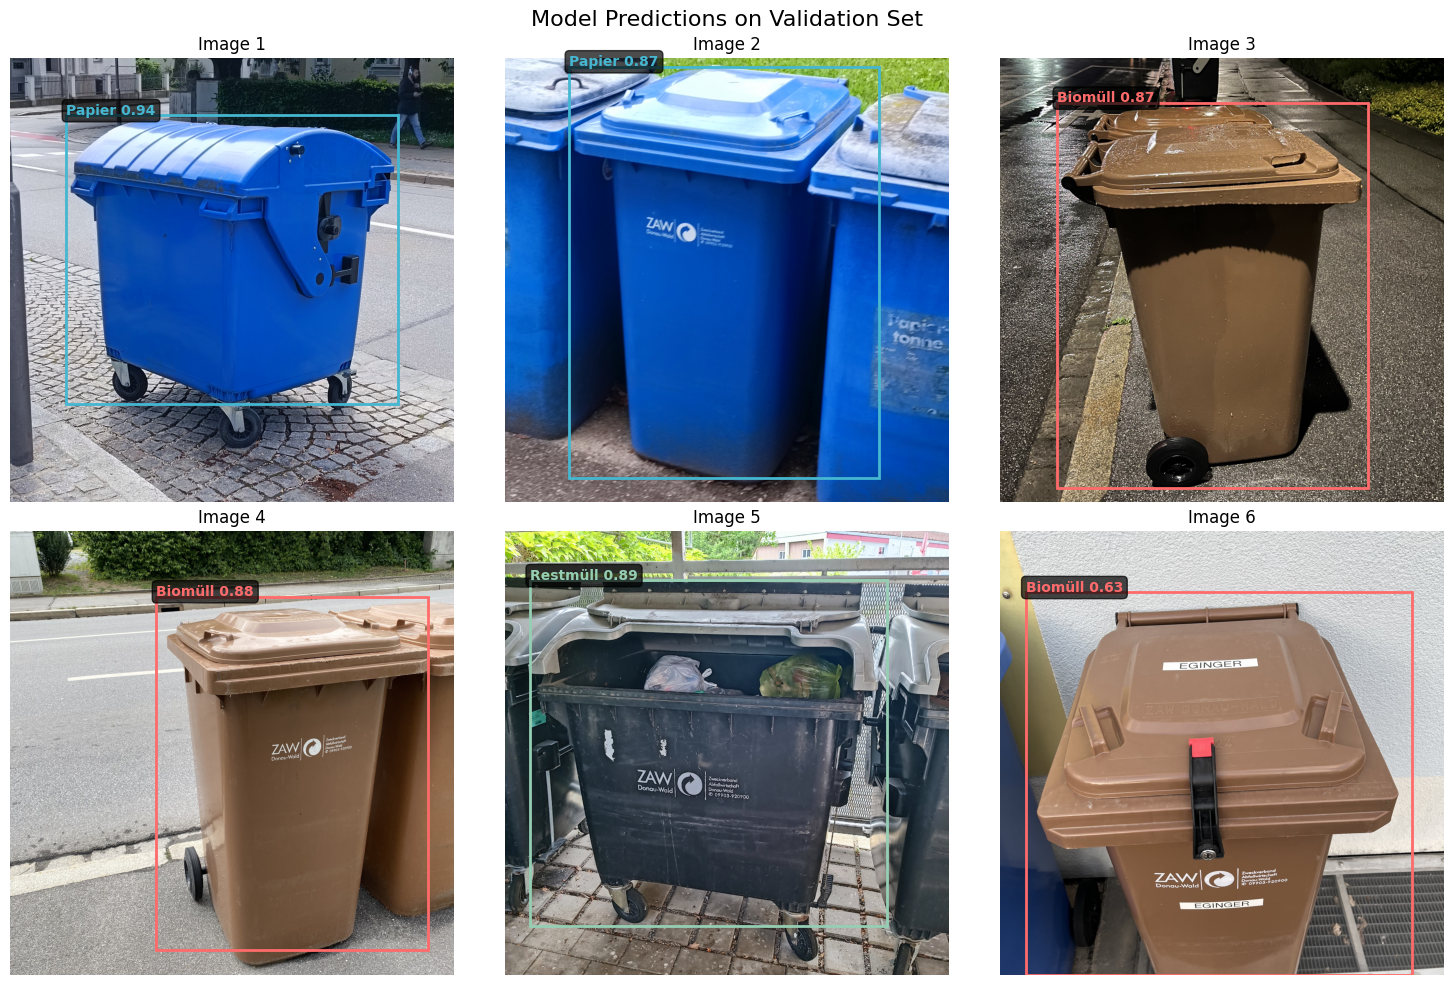

✅ Visualization saved to: /content/drive/MyDrive/cv_garbage/results/validation_predictions.png


In [9]:
# 4.2 · Visualize predictions on validation set
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.patches import Rectangle

def visualize_predictions(model_path, data_yaml_path, num_samples=6):
    """Visualize model predictions on validation images"""

    # Load model and data config
    model = YOLO(model_path)
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Get validation images
    val_images_dir = Path(data_yaml_path).parent / data_config['val']
    val_images = list(val_images_dir.glob("*.jpg")) + list(val_images_dir.glob("*.png"))

    if not val_images:
        print("No validation images found!")
        return

    # Sample random images
    sample_images = np.random.choice(val_images, min(num_samples, len(val_images)), replace=False)

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    colors = {
        0: '#FF6B6B',  # Biomüll - Red
        1: '#4ECDC4',  # Glas - Turquoise
        2: '#45B7D1',  # Papier - Blue
        3: '#96CEB4'   # Restmüll - Green
    }

    for idx, (ax, img_path) in enumerate(zip(axes, sample_images)):
        # Read image
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Run prediction
        results = model.predict(img_path, conf=0.25, iou=0.45)

        # Display image
        ax.imshow(img_rgb)
        ax.axis('off')

        # Draw predictions
        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])

                    # Draw rectangle
                    rect = Rectangle((x1, y1), x2-x1, y2-y1,
                                   linewidth=2, edgecolor=colors.get(cls, 'white'),
                                   facecolor='none')
                    ax.add_patch(rect)

                    # Add label
                    label = f"{model.names[cls]} {conf:.2f}"
                    ax.text(x1, y1-5, label, color=colors.get(cls, 'white'),
                           fontsize=10, weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

        ax.set_title(f"Image {idx+1}")

    plt.suptitle("Model Predictions on Validation Set", fontsize=16)
    plt.tight_layout()

    # Save figure
    output_path = DIRS["results"] / "validation_predictions.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualization saved to: {output_path}")

# Run visualization
if 'final_model_path' in locals():
    visualize_predictions(
        final_model_path,
        DIRS["yolo_dataset"] / "data.yaml",
        num_samples=6
    )

---


## **5. Model Deployment with Live Camera**


### **5.1 Camera Access Setup**

First, let's create helper functions for camera access that work in both environments:

In [10]:
# 5.1 · Camera access setup
import cv2
import numpy as np
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
import PIL
import io

def is_colab():
    """Check if running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Define waste disposal information
WASTE_INFO = {
    "Biomüll": {
        "color": "#FF6B6B",
        "items": ["Food scraps", "Vegetable peels", "Coffee grounds", "Tea bags", "Garden waste"]
    },
    "Glas": {
        "color": "#4ECDC4",
        "items": ["Glass bottles", "Glass jars", "Drinking glasses (no ceramics!)"]
    },
    "Papier": {
        "color": "#45B7D1",
        "items": ["Newspapers", "Magazines", "Cardboard", "Paper bags", "Books"]
    },
    "Restmüll": {
        "color": "#96CEB4",
        "items": ["Cigarette butts", "Diapers", "Used tissues", "Broken ceramics"]
    }
}

print("✅ Camera helper functions loaded")
print(f"📍 Running in: {'Google Colab' if is_colab() else 'Local environment'}")

✅ Camera helper functions loaded
📍 Running in: Google Colab


### **5.2 Google Colab Camera Access**

For Google Colab, we'll use JavaScript to access the camera through the browser:

In [21]:
# 5.2 · Google Colab Live Camera with YOLO Predictions
if is_colab():
    from google.colab.output import eval_js
    from google.colab.patches import cv2_imshow
    from IPython.display import display, Javascript, HTML
    import base64
    import json

    def create_live_camera_interface():
        """Create HTML/JS interface for live camera with predictions"""
        html_code = """
        <div id="camera-container" style="text-align: center;">
            <h3>🎥 Live Waste Bin Detection</h3>
            <div id="camera-selection" style="margin: 10px;">
                <label for="cameraSelect" style="font-weight: bold;">Select Camera: </label>
                <select id="cameraSelect" style="padding: 5px; font-size: 14px;">
                    <option value="">Loading cameras...</option>
                </select>
                <button onclick="refreshCameras()" style="margin-left: 10px; padding: 5px 10px;">🔄 Refresh</button>
            </div>
            <div style="position: relative; display: inline-block;">
                <video id="video" width="640" height="480" autoplay style="border: 2px solid #333; margin-top: 10px;"></video>
                <canvas id="overlay" width="640" height="480" style="position: absolute; top: 10px; left: 0; pointer-events: none;"></canvas>
            </div>
            <canvas id="canvas" width="640" height="480" style="display: none;"></canvas>
            <br>
            <button id="startBtn" onclick="startCamera()" style="margin: 10px; padding: 10px 20px; font-size: 16px;">Start Camera</button>
            <button id="stopBtn" onclick="stopCamera()" style="margin: 10px; padding: 10px 20px; font-size: 16px;" disabled>Stop Camera</button>
            <div id="status" style="margin: 10px; font-weight: bold;"></div>
            <div id="predictions" style="margin: 20px; text-align: left; max-width: 640px; margin: 0 auto;"></div>
        </div>

        <script>
        let stream = null;
        let captureInterval = null;
        let isProcessing = false;
        let currentDeviceId = null;

        // Enumerate cameras on page load
        window.addEventListener('load', () => {
            enumerateCameras();
        });

        async function enumerateCameras() {
            try {
                // Request camera permission first
                await navigator.mediaDevices.getUserMedia({ video: true }).then(s => s.getTracks().forEach(t => t.stop()));

                const devices = await navigator.mediaDevices.enumerateDevices();
                const videoDevices = devices.filter(device => device.kind === 'videoinput');

                const select = document.getElementById('cameraSelect');
                select.innerHTML = '';

                if (videoDevices.length === 0) {
                    select.innerHTML = '<option value="">No cameras found</option>';
                    document.getElementById('status').textContent = '❌ No cameras detected';
                    return;
                }

                videoDevices.forEach((device, index) => {
                    const option = document.createElement('option');
                    option.value = device.deviceId;
                    option.text = device.label || `Camera ${index + 1}`;
                    select.appendChild(option);
                });

                // Select first camera by default
                currentDeviceId = videoDevices[0].deviceId;
                document.getElementById('status').textContent = `📷 ${videoDevices.length} camera(s) found`;

            } catch (err) {
                console.error('Camera enumeration error:', err);
                document.getElementById('status').textContent = '❌ Cannot access cameras';
            }
        }

        function refreshCameras() {
            stopCamera();
            enumerateCameras();
        }

        async function startCamera() {
            try {
                const video = document.getElementById('video');
                const canvas = document.getElementById('canvas');
                const ctx = canvas.getContext('2d');
                const selectedDeviceId = document.getElementById('cameraSelect').value;

                if (!selectedDeviceId) {
                    document.getElementById('status').textContent = '⚠️ Please select a camera';
                    return;
                }

                // Stop any existing stream
                if (stream) {
                    stream.getTracks().forEach(track => track.stop());
                }

                // Get camera stream with selected device
                const constraints = {
                    video: {
                        deviceId: { exact: selectedDeviceId },
                        width: { ideal: 640 },
                        height: { ideal: 480 }
                    }
                };

                stream = await navigator.mediaDevices.getUserMedia(constraints);
                video.srcObject = stream;

                // Wait for video to be ready
                await new Promise((resolve) => {
                    video.onloadedmetadata = () => resolve();
                });

                document.getElementById('startBtn').disabled = true;
                document.getElementById('stopBtn').disabled = false;
                document.getElementById('cameraSelect').disabled = true;
                document.getElementById('status').textContent = '🟢 Camera active - Processing frames...';

                // Start capturing frames
                captureInterval = setInterval(async () => {
                    if (!isProcessing && video.readyState === video.HAVE_ENOUGH_DATA) {
                        isProcessing = true;

                        // Draw current frame to canvas
                        ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

                        // Convert to base64
                        const imageData = canvas.toDataURL('image/jpeg', 0.8);

                        // Send to Python for processing
                        google.colab.kernel.invokeFunction('process_frame', [imageData], {});

                        // Small delay to prevent overwhelming
                        setTimeout(() => { isProcessing = false; }, 100);
                    }
                }, 200); // Capture every 200ms (5 FPS)

            } catch (err) {
                console.error('Camera error:', err);
                if (err.name === 'NotFoundError') {
                    document.getElementById('status').textContent = '❌ Selected camera not found';
                } else if (err.name === 'NotAllowedError') {
                    document.getElementById('status').textContent = '❌ Camera access denied';
                } else {
                    document.getElementById('status').textContent = '❌ Camera error: ' + err.message;
                }
                document.getElementById('startBtn').disabled = false;
                document.getElementById('stopBtn').disabled = true;
            }
        }

        function stopCamera() {
            if (stream) {
                stream.getTracks().forEach(track => track.stop());
                stream = null;
            }
            if (captureInterval) {
                clearInterval(captureInterval);
                captureInterval = null;
            }

            document.getElementById('video').srcObject = null;
            document.getElementById('startBtn').disabled = false;
            document.getElementById('stopBtn').disabled = true;
            document.getElementById('cameraSelect').disabled = false;
            document.getElementById('status').textContent = '⏹️ Camera stopped';
            document.getElementById('predictions').innerHTML = '';

            // Clear overlay canvas
            const overlayCanvas = document.getElementById('overlay');
            const ctx = overlayCanvas.getContext('2d');
            ctx.clearRect(0, 0, overlayCanvas.width, overlayCanvas.height);

            isProcessing = false;
        }

        // Camera selection change handler
        document.getElementById('cameraSelect').addEventListener('change', function() {
            if (stream) {
                // If camera is running, restart with new selection
                stopCamera();
                setTimeout(() => startCamera(), 100);
            }
        });

        // Function to update predictions display
        window.updatePredictions = function(predictions) {
            const predDiv = document.getElementById('predictions');
            const overlayCanvas = document.getElementById('overlay');
            const ctx = overlayCanvas.getContext('2d');

            // Clear previous overlay
            ctx.clearRect(0, 0, overlayCanvas.width, overlayCanvas.height);

            if (predictions.length === 0) {
                predDiv.innerHTML = '<p style="color: #666;">No bins detected</p>';
            } else {
                let html = '<h4>Detected Bins:</h4>';

                predictions.forEach(pred => {
                    // Draw bounding box
                    ctx.strokeStyle = pred.color;
                    ctx.lineWidth = 3;
                    ctx.strokeRect(pred.x1, pred.y1, pred.x2 - pred.x1, pred.y2 - pred.y1);

                    // Optional: Add corner markers for better visibility
                    const cornerLength = 15;
                    ctx.lineWidth = 4;

                    // Top-left corner
                    ctx.beginPath();
                    ctx.moveTo(pred.x1, pred.y1 + cornerLength);
                    ctx.lineTo(pred.x1, pred.y1);
                    ctx.lineTo(pred.x1 + cornerLength, pred.y1);
                    ctx.stroke();

                    // Top-right corner
                    ctx.beginPath();
                    ctx.moveTo(pred.x2 - cornerLength, pred.y1);
                    ctx.lineTo(pred.x2, pred.y1);
                    ctx.lineTo(pred.x2, pred.y1 + cornerLength);
                    ctx.stroke();

                    // Bottom-left corner
                    ctx.beginPath();
                    ctx.moveTo(pred.x1, pred.y2 - cornerLength);
                    ctx.lineTo(pred.x1, pred.y2);
                    ctx.lineTo(pred.x1 + cornerLength, pred.y2);
                    ctx.stroke();

                    // Bottom-right corner
                    ctx.beginPath();
                    ctx.moveTo(pred.x2 - cornerLength, pred.y2);
                    ctx.lineTo(pred.x2, pred.y2);
                    ctx.lineTo(pred.x2, pred.y2 - cornerLength);
                    ctx.stroke();

                    ctx.lineWidth = 3; // Reset line width

                    // Draw label background
                    const label = `${pred.class} (${pred.confidence}%)`;
                    ctx.font = 'bold 16px Arial';
                    const textWidth = ctx.measureText(label).width;
                    const textHeight = 20;

                    // Background rectangle for label
                    ctx.fillStyle = pred.color;
                    ctx.fillRect(pred.x1, pred.y1 - textHeight - 4, textWidth + 10, textHeight + 4);

                    // Draw label text
                    ctx.fillStyle = 'white';
                    ctx.fillText(label, pred.x1 + 5, pred.y1 - 6);

                    // Update HTML predictions
                    html += `
                        <div style="background: ${pred.color}22; border-left: 4px solid ${pred.color};
                                    padding: 10px; margin: 5px 0; border-radius: 4px;">
                            <strong style="color: ${pred.color};">${pred.class}</strong>
                            (${pred.confidence}% confidence)<br>
                            <small>Dispose: ${pred.items}</small>
                        </div>
                    `;
                });

                predDiv.innerHTML = html;
            }
        }
        </script>
        """
        display(HTML(html_code))

    def setup_frame_processor(model_path, conf_threshold=0.5, box_thickness=3):
        """Setup the frame processing callback with bounding boxes

        Args:
            model_path: Path to YOLO model
            conf_threshold: Confidence threshold for detections (0-1)
            box_thickness: Thickness of bounding boxes in pixels
        """
        from google.colab import output

        # Load model once
        model = YOLO(model_path)

        def process_frame(image_data):
            """Process a single frame from the camera"""
            try:
                # Decode base64 image
                image_data = image_data.split(',')[1]
                image_bytes = base64.b64decode(image_data)

                # Convert to PIL Image then numpy array
                pil_image = PIL.Image.open(io.BytesIO(image_bytes))
                frame = np.array(pil_image)
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

                # Get frame dimensions
                height, width = frame.shape[:2]

                # Run YOLO inference
                results = model.predict(frame, conf=conf_threshold, iou=0.45, verbose=False)[0]

                # Process predictions
                predictions = []
                for box in results.boxes:
                    if box.conf[0] > conf_threshold:  # Confidence threshold
                        cls_id = int(box.cls[0])
                        cls_name = model.names[cls_id]
                        confidence = int(box.conf[0] * 100)

                        # Get bounding box coordinates
                        x1, y1, x2, y2 = box.xyxy[0].tolist()

                        # Scale coordinates to canvas size (640x480)
                        scale_x = 640 / width
                        scale_y = 480 / height

                        # Get waste info
                        waste_data = WASTE_INFO.get(cls_name, {})

                        predictions.append({
                            'class': cls_name,
                            'confidence': confidence,
                            'color': waste_data.get('color', '#666'),
                            'items': ', '.join(waste_data.get('items', ['No info'])[:2]),
                            'x1': int(x1 * scale_x),
                            'y1': int(y1 * scale_y),
                            'x2': int(x2 * scale_x),
                            'y2': int(y2 * scale_y)
                        })

                # Update the display with JavaScript
                output.eval_js(f'window.updatePredictions({json.dumps(predictions)})')

            except Exception as e:
                print(f"Frame processing error: {e}")

        # Register the callback
        output.register_callback('process_frame', process_frame)
        print(f"✅ Frame processor registered (confidence threshold: {conf_threshold})")
        return model

    # Alternative: Simpler frame-by-frame capture with display
    def live_detection_simple(model_path, duration=30):
        """Simpler live detection that captures and displays frames with bounding boxes"""
        print("🎥 Starting live detection (press Stop Runtime to end)")

        model = YOLO(model_path)
        frame_count = 0

        while frame_count < duration * 5:  # Approximate 5 FPS
            try:
                # Capture frame
                print(f"\rCapturing frame {frame_count+1}...", end='')
                image_data = eval_js('''
                    (async function() {
                        const video = document.createElement('video');
                        const canvas = document.createElement('canvas');

                        const stream = await navigator.mediaDevices.getUserMedia({video: true});
                        video.srcObject = stream;
                        video.play();

                        await new Promise(resolve => video.onloadedmetadata = resolve);
                        await new Promise(resolve => setTimeout(resolve, 100));

                        canvas.width = video.videoWidth;
                        canvas.height = video.videoHeight;
                        canvas.getContext('2d').drawImage(video, 0, 0);

                        stream.getTracks().forEach(track => track.stop());

                        return canvas.toDataURL('image/jpeg', 0.8);
                    })()
                ''')

                # Process image
                image_bytes = base64.b64decode(image_data.split(',')[1])
                pil_image = PIL.Image.open(io.BytesIO(image_bytes))
                frame = np.array(pil_image)
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

                # Run inference
                results = model.predict(frame, conf=0.5, iou=0.45, verbose=False)[0]

                # Get annotated frame with bounding boxes
                annotated_frame = results.plot()

                # Add custom overlay with disposal info
                y_offset = 30
                for box in results.boxes:
                    if box.conf[0] > 0.5:
                        cls_id = int(box.cls[0])
                        cls_name = model.names[cls_id]
                        confidence = int(box.conf[0] * 100)

                        # Get waste info
                        waste_data = WASTE_INFO.get(cls_name, {})
                        items = waste_data.get('items', ['No info'])[:2]

                        # Add detection info with background
                        text = f"{cls_name} ({confidence}%): {', '.join(items)}"
                        (text_width, text_height), baseline = cv2.getTextSize(
                            text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
                        )

                        # Draw background rectangle
                        cv2.rectangle(annotated_frame,
                                    (10, y_offset - text_height - 5),
                                    (15 + text_width, y_offset + 5),
                                    (0, 0, 0), -1)

                        # Draw text
                        cv2.putText(annotated_frame, text, (10, y_offset),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                        y_offset += 35

                # Clear previous output and display new frame
                from IPython.display import clear_output
                clear_output(wait=True)

                print(f"Frame {frame_count+1} - Detections: {len(results.boxes)}")
                cv2_imshow(annotated_frame)

                frame_count += 1
                time.sleep(0.2)  # ~5 FPS

            except KeyboardInterrupt:
                print("\n⏹️ Detection stopped by user")
                break
            except Exception as e:
                print(f"\n❌ Error: {e}")
                time.sleep(1)

        print(f"\n✅ Processed {frame_count} frames")

    # Example usage functions
    def start_live_detection_interactive(model_path, conf_threshold=0.5):
        """Start the interactive live detection interface with bounding boxes

        Args:
            model_path: Path to YOLO model
            conf_threshold: Confidence threshold for detections (0-1)
        """
        print("🚀 Initializing live camera interface with bounding boxes...")

        # Create the HTML interface
        create_live_camera_interface()

        # Setup frame processor
        model = setup_frame_processor(model_path, conf_threshold)

        print("\n📌 Instructions:")
        print("1. Select your camera from the dropdown")
        print("2. Click 'Start Camera' to begin")
        print("3. Point camera at waste bins")
        print("4. Bounding boxes will appear around detected bins")
        print("5. Predictions will appear below the video")
        print("6. Click 'Stop Camera' when done")
        print("\n💡 Tips:")
        print("- Use 'Refresh' button if cameras change")
        print("- Camera automatically restarts when selection changes")
        print(f"- Detection confidence threshold: {conf_threshold}")
        print("- Bounding boxes are color-coded by waste type")

    # Enhanced camera test function
    def test_cameras():
        """Test and list all available cameras with preview"""
        test_html = """
        <div style="text-align: center;">
            <h3>📷 Camera Test</h3>
            <div id="camera-list"></div>
            <button onclick="testAllCameras()" style="padding: 10px 20px; margin: 10px;">Test All Cameras</button>
            <div id="test-results" style="margin: 20px;"></div>
        </div>

        <script>
        async function testAllCameras() {
            const resultsDiv = document.getElementById('test-results');
            resultsDiv.innerHTML = '<p>Testing cameras...</p>';

            try {
                // Request permission first
                await navigator.mediaDevices.getUserMedia({ video: true }).then(s => s.getTracks().forEach(t => t.stop()));

                const devices = await navigator.mediaDevices.enumerateDevices();
                const videoDevices = devices.filter(device => device.kind === 'videoinput');

                resultsDiv.innerHTML = '';

                for (let i = 0; i < videoDevices.length; i++) {
                    const device = videoDevices[i];
                    const container = document.createElement('div');
                    container.style.cssText = 'margin: 10px; padding: 10px; border: 1px solid #ddd; border-radius: 5px;';

                    const title = document.createElement('h4');
                    title.textContent = device.label || `Camera ${i + 1}`;
                    container.appendChild(title);

                    const video = document.createElement('video');
                    video.width = 320;
                    video.height = 240;
                    video.autoplay = true;
                    video.style.cssText = 'border: 1px solid #333;';

                    try {
                        const stream = await navigator.mediaDevices.getUserMedia({
                            video: { deviceId: { exact: device.deviceId } }
                        });
                        video.srcObject = stream;

                        const info = document.createElement('p');
                        info.style.color = 'green';
                        info.textContent = '✅ Camera working';
                        container.appendChild(info);

                        // Stop after 3 seconds
                        setTimeout(() => {
                            stream.getTracks().forEach(track => track.stop());
                            video.srcObject = null;
                        }, 3000);

                    } catch (err) {
                        const error = document.createElement('p');
                        error.style.color = 'red';
                        error.textContent = '❌ Camera not accessible: ' + err.message;
                        container.appendChild(error);
                    }

                    container.appendChild(video);
                    resultsDiv.appendChild(container);
                }

                if (videoDevices.length === 0) {
                    resultsDiv.innerHTML = '<p style="color: red;">No cameras found!</p>';
                }

            } catch (err) {
                resultsDiv.innerHTML = '<p style="color: red;">Error: ' + err.message + '</p>';
            }
        }
        </script>
        """
        display(HTML(test_html))

    # Display usage options
    print("\n🎥 Live Camera Detection with Bounding Boxes:")
    print("\n1. Test Available Cameras:")
    print("   test_cameras()")
    print("\n2. Interactive Interface with Live Bounding Boxes:")
    print("   start_live_detection_interactive(final_model_path)")
    print("   # Optional: adjust confidence threshold")
    print("   start_live_detection_interactive(final_model_path, conf_threshold=0.6)")
    print("\n3. Simple Frame Display with Bounding Boxes:")
    print("   live_detection_simple(final_model_path, duration=30)")
    print("\n📦 Features:")
    print("- Real-time bounding boxes around detected trash bins")
    print("- Color-coded boxes matching waste type")
    print("- Confidence scores displayed on boxes")
    print("- Disposal information for each detected bin")

else:
    print("❌ This cell is for Google Colab only. Use OpenCV for local environment.")


🎥 Live Camera Detection with Bounding Boxes:

1. Test Available Cameras:
   test_cameras()

2. Interactive Interface with Live Bounding Boxes:
   start_live_detection_interactive(final_model_path)
   # Optional: adjust confidence threshold
   start_live_detection_interactive(final_model_path, conf_threshold=0.6)

3. Simple Frame Display with Bounding Boxes:
   live_detection_simple(final_model_path, duration=30)

📦 Features:
- Real-time bounding boxes around detected trash bins
- Color-coded boxes matching waste type
- Confidence scores displayed on boxes
- Disposal information for each detected bin


In [22]:
test_cameras()

In [24]:
if 'final_model_path' in locals():
    start_live_detection_interactive(final_model_path, conf_threshold=0.8)

🚀 Initializing live camera interface with bounding boxes...


✅ Frame processor registered (confidence threshold: 0.8)

📌 Instructions:
1. Select your camera from the dropdown
2. Click 'Start Camera' to begin
3. Point camera at waste bins
4. Bounding boxes will appear around detected bins
5. Predictions will appear below the video
6. Click 'Stop Camera' when done

💡 Tips:
- Use 'Refresh' button if cameras change
- Camera automatically restarts when selection changes
- Detection confidence threshold: 0.8
- Bounding boxes are color-coded by waste type


### **5.3 Live Video Streaming**


In [15]:
# 1. Imports and model load
from ultralytics import YOLO
import cv2, time

# Define what can go where
bin_rules = {
    "Biomüll": ["Food scraps", "Eggshells", "Tea bags"],
    "Papier":  ["Newspapers", "Cardboard", "Envelopes"],
    "Restmüll": ["Cigarette butts", "Vacuum cleaner bags", "Hygiene products"],
    "Glas": ["Bottles", "Jars (without lids)"]
}

# 2. Load your best model weights from the path you provided
model = YOLO(best_model_path)

# 4. Your DroidCam HTTP stream URL
stream_url = "http://100.83.17.254:4747/video"

# 3. Streaming parameters
CONF = 0.65
IOU = 0.35
SIZE = 960



# Force OpenCV to use FFMPEG backend
cap = cv2.VideoCapture(0)

while True:
    ok, frame = cap.read()
    if not ok:
        print("❌ Stream lost"); break

    t0 = time.time()

    # Run prediction
    results = model.predict(frame, imgsz=SIZE, conf=CONF, iou=IOU, stream=False)[0]

    # Copy the annotated frame
    annotated = results.plot().copy()

    for box in results.boxes:
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]

        x1, y1 = int(box.xyxy[0][0]), int(box.xyxy[0][1])
        info = bin_rules.get(cls_name, ["No info available"])
        text = f"{cls_name}: " + ", ".join(info[:2])  # Show up to 2 items

        # Draw text
        # Calculate text size
        (font_w, font_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_DUPLEX, 0.6, 1)

        # Coordinates for the background rectangle
        rect_x1 = x1
        rect_y1 = y1 + 5
        rect_x2 = x1 + font_w + 10
        rect_y2 = y1 + font_h + 20

        # Ensure the box doesn't go out of frame
        rect_x2 = min(rect_x2, annotated.shape[1] - 1)
        rect_y2 = min(rect_y2, annotated.shape[0] - 1)

        # Draw background rectangle (filled with opacity)
        overlay = annotated.copy()
        cv2.rectangle(overlay, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 0), -1)
        alpha = 0.5
        annotated = cv2.addWeighted(overlay, alpha, annotated, 1 - alpha, 0)

        # Draw the text over the rectangle
        cv2.putText(annotated, text, (x1 + 5, y1 + font_h + 5),
            cv2.FONT_HERSHEY_DUPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    # Show FPS
    fps = 1.0 / (time.time() - t0)
    cv2.putText(annotated, f"{fps:.1f} FPS", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display result
    cv2.imshow("Trash Bin Detection", annotated)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

❌ Stream lost


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [13]:
# Rum a prediction on a sample image
if 'final_model_path' in locals():
    # Test on a sample image
    test_image = Path("C:/Users/rudae/Documents/UniUA/Painfully-Trivial/IMG_20250627_174033.jpg")
    if test_image.exists():
        print("\n🔍 Running inference on sample image...")
        run_inference(final_model_path, str(test_image))
    else:
        print(f"❌ Sample image not found: {test_image}")

❌ Sample image not found: C:/Users/rudae/Documents/UniUA/Painfully-Trivial/IMG_20250627_174033.jpg
